In [1]:
%matplotlib inline
#
from os import chdir, getcwd
ROOTF = 'LRG-Signed'
if getcwd()[-len(ROOTF):] != ROOTF:
    chdir('../')
print('cwd:', getcwd())
#
from src.LRGSG_package.LRGSG import *

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [2]:
L = 32
lattice_geometry = 'squared'

In [3]:
sqLattice = Lattice2D(#
    side1 = L,
    geometry = lattice_geometry
)
SLRG_obj = SignedLaplacianAnalysis(#
    system = sqLattice,
    pflip = 0.01,
    t2 = 3.5
)

In [2]:
L = 30
no_obs = 5
T_STEPS = 10
Deltat = 1/T_STEPS
simulationTime = 1000*T_STEPS
sampling = 1*T_STEPS
frames = simulationTime // sampling
initial_cond = 'gauss_1'
BC_choice = 'FBC'
fbc_val = 1

In [3]:
neg_weightsG = {((L//2,L//2), (L//2,L//2+1)): -1}
neg_weightsH = {(0, 10): -1}
fraction_to_flip = 0.05
#
G = nx.grid_2d_graph(L, L, periodic=True)
nx.set_edge_attributes(G, values=1, name='weight')
nx.set_edge_attributes(G, values=neg_weightsG, name='weight')
# flip_random_fract_edges(G, fraction_to_flip)
H = nx.convert_node_labels_to_integers(G)
# nx.set_edge_attributes(H, values=neg_weightsH, name='weight')
#
neighbor_dictG = nx.single_source_shortest_path_length(G, (0, 0))
neighbor_dictH = nx.single_source_shortest_path_length(H, 0)
#
Gedges = list(G.edges(data=True))
neg_weightsG = [i for i in Gedges if i[2]['weight'] == -1]
Hedges = list(H.edges(data=True))
neg_weightsH = [i for i in Hedges if i[2]['weight'] == -1]
#
print('Flipped edges:', '\nG graph', neg_weightsG, '\nH graph', neg_weightsH, '[+ G negative edges]')

Flipped edges: 
G graph [((15, 15), (15, 16), {'weight': -1})] 
H graph [(465, 466, {'weight': -1})] [+ G negative edges]


In [4]:
# laplacian and signed laplacian matrix
adj = nx.adjacency_matrix(G).toarray()
dia = np.diag(adj.sum(axis=1))
lapl = dia - adj
diabs = np.diag(np.abs(adj).sum(axis=1))
slapl = diabs - adj
eigv, eigV = np.linalg.eigh(slapl)

In [5]:
if initial_cond == 'uniform_1':
    status_array = np.random.uniform(-1, 1, L**2)#np.ones(L**2)
elif initial_cond == 'delta_1':
    status_array = np.zeros(L**2)
    status_array[L**2//2] = L**2
elif initial_cond == 'gauss_1':
    status_array = np.random.normal(0, 1, L**2)
elif initial_cond.startswith('ground_state'):
    eigenMode = int(initial_cond.split('_')[-1])
#
if BC_choice == 'FBC':
    # fixed_indices = np.array(list(set(
    #                   np.concatenate([[i for i in range(L)], 
    #                         [i for i in range(L**2) if i % L ==0], 
    #                         [i for i in range(L**2) if (i+1) % (L) ==0],
    #                         [i for i in range(L**2-L, L**2)]]))))
    fixed_border_idxs = np.array(sorted([i for i in range(L)] + \
                [(L-1) * L + i for i in range(L)] + \
                [i * L for i in range(1, L-1)] + 
                [(i+1) * L - 1 for i in range(1, L-1)]))
    status_array[fixed_border_idxs] = fbc_val

In [6]:
frames_dynsys = []

In [11]:
for t in range(simulationTime):
    status_array_old = status_array
    if ((t) % sampling == 0):
        print(t, np.mean(status_array), np.var(status_array))
        frames_dynsys.append(status_array_old.reshape(L, L))
    status_array = status_array - Deltat*(slapl@status_array) #+ np.sqrt(Deltat)*np.random.uniform(-1e-3, 1e-3, L**2)
    status_array[fixed_border_idxs] = fbc_val
    # if (np.abs(status_array_old - status_array) < 1e-7*np.ones(L**2)).all():
    #     print('Convergence reached')
    #     break

0 0.9165416007551012 0.009047455244978589
10 0.9165416007551012 0.009047455244978589
20 0.9165416007551012 0.009047455244978589
30 0.9165416007551012 0.009047455244978589
40 0.9165416007551012 0.009047455244978589
50 0.9165416007551012 0.009047455244978589
60 0.9165416007551012 0.009047455244978589
70 0.9165416007551012 0.009047455244978589
80 0.9165416007551012 0.009047455244978589
90 0.9165416007551012 0.009047455244978589
100 0.9165416007551012 0.009047455244978589
110 0.9165416007551012 0.009047455244978589
120 0.9165416007551012 0.009047455244978589
130 0.9165416007551012 0.009047455244978589
140 0.9165416007551012 0.009047455244978589
150 0.9165416007551012 0.009047455244978589
160 0.9165416007551012 0.009047455244978589
170 0.9165416007551012 0.009047455244978589
180 0.9165416007551012 0.009047455244978589
190 0.9165416007551012 0.009047455244978589
200 0.9165416007551012 0.009047455244978589
210 0.9165416007551012 0.009047455244978589
220 0.9165416007551012 0.009047455244978589

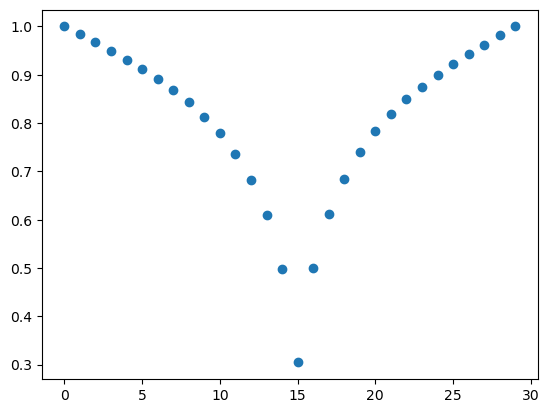

In [16]:
# plt.imshow(status_array.reshape(L, L))
# plt.colorbar()
plt.plot(status_array.reshape(L, L)[:, L//2], 'o')

In [2]:
# def radial_correlation(field, neighbor_dict, central_index):
#     # Flatten the field array
#     flattened_field = field.flatten()
#     # Compute the mean of the field values
#     mean_field = np.mean(flattened_field)
#     # Compute the correlation function
#     correlation = []
#     for node, neighbors in neighbor_dict.items():
#         correlations_node = []
#         for neighbor_index in neighbors:
#             correlation_node = np.mean((flattened_field[central_index] - mean_field) * flattened_field[neighbor_index]) / np.std(flattened_field) ** 2
#             correlations_node.append(correlation_node)
#         correlation.append(np.mean(correlations_node))

#     return correlation


In [3]:
# def radial_correlation(G, field, central_node):
#     neighbor_dict = nx.single_source_shortest_path_length(G, central_node)
#     mean_field = np.mean(field)
#     flattened_field = field.flatten()
    
#     # Compute the correlation function
#     correlation = []
#     for r in range(int(np.sqrt(G.number_of_nodes()))):
#         kth_order_neighbors = [np.array(n) for n, d in neighbor_dict.items() if d == r]
#         mask = (distances == r)
#         if np.any(mask):
#             correlation.append([r, np.mean((flattened_field - mean_field) * np.roll(flattened_field, r)) / np.std(flattened_field)**2])
    
#     return correlation

In [4]:

# neighbor_dict = nx.single_source_shortest_path_length(G, central_node)
# mean_field = np.mean(field)
# flattened_field = field.flatten()
# correlation = []
# for r in range(int(np.sqrt(G.number_of_nodes()))):
#     kth_order_neighbors = [np.array(n) for n, d in neighbor_dict.items() if d == r]
#     for 
#     mask = (distances == r)
#     if np.any(mask):
#         correlation.append([r, np.mean((flattened_field - mean_field) * np.roll(flattened_field, r)) / np.std(flattened_field)**2])

In [9]:
L = 16
no_obs = 5
T_STEPS = 200
Deltat = 1/T_STEPS
simulationTime = 1000*T_STEPS
sampling = 1*T_STEPS
frames = simulationTime // sampling
initial_cond = 'gauss_1'
BC_choice = 'FBC'

In [10]:
G = nx.grid_2d_graph(L, L, periodic=True if BC_choice == 'PBC' else False)
pos = dict(zip(G,G)) # dictionary of node names->positions
nx.set_node_attributes(G, pos, 'pos')
nx.set_edge_attributes(G, values=1, name='weight')
# flip_random_fract_edges(G, 1/G.number_of_edges())
flip_one_2dgraph(G, (L//2, L//2), (L//2, L//2+1))
# flip_one_2dgraph(G, (L//3, L//3), (L//3, L//3+1))
negative_edges = [(u, v, w) for u, v, w in G.edges(data='weight') if w < 0]
adj = nx.adjacency_matrix(G).toarray()
dia = np.diag(adj.sum(axis=1))
lapl = dia - adj
diabs = np.diag(np.abs(adj).sum(axis=1))
slapl = diabs - adj
eigv, eigV = np.linalg.eigh(slapl)

In [11]:
if initial_cond == 'uniform_1':
    status_array = np.random.uniform(0, 1, L**2)#np.ones(L**2)
elif initial_cond == 'delta_1':
    status_array = np.zeros(L**2)
    status_array[0] = L**2
elif initial_cond == 'gauss_1':
    status_array = np.random.normal(0, 1, L**2)
elif initial_cond.startswith('ground_state'):
    eigenMode = int(initial_cond.split('_')[-1])
#
if BC_choice == 'FBC':
    # fixed_indices = np.array(list(set(
    #                   np.concatenate([[i for i in range(L)], 
    #                         [i for i in range(L**2) if i % L ==0], 
    #                         [i for i in range(L**2) if (i+1) % (L) ==0],
    #                         [i for i in range(L**2-L, L**2)]]))))
    fixed_border_idxs = np.array(sorted([i for i in range(L)] + \
                [(L-1) * L + i for i in range(L)] + \
                [i * L for i in range(1, L-1)] + 
                [(i+1) * L - 1 for i in range(1, L-1)]))
    status_array[fixed_border_idxs] = 0.5


In [12]:
status_distributionp = {}
status_distributionx = {}
frames_dynsys = []
for t in range(simulationTime):
    status_array_old = status_array
    if ((t) % sampling == 0):
        print(t, np.mean(status_array), np.var(status_array))
        frames_dynsys.append(status_array_old.reshape(L, L))
    status_array = status_array - Deltat*(slapl@status_array) #+ np.sqrt(Deltat)*np.random.uniform(-1e-3, 1e-3, L**2)
    status_array[fixed_border_idxs] = 0.5
    if (np.abs(status_array_old - status_array) < 1e-7*np.ones(L**2)).all():
        print('Convergence reached')
        break
        # plt.hist(status_array, bins=30, range=[-3, 3])
    #     hist, bins = np.histogram(status_array, bins=20)
    #     center = (bins[:-1] + bins[1:]) / 2
    #     # plt.plot(center, hist, 'o-', label=fr"$t={t:g}$")
# plt.hist(status_array, bins=20)
# bhbwp, bhbwn = symlog_binning(status_array, binnum=50)
# if bhbwp:
#     plt.plot(bhbwp[0], bhbwp[1], label=fr"$t={t+1}$")
# if bhbwn:
#     plt.plot(bhbwn[0], bhbwn[1], color=plt.gca().lines[-1].get_color())

0 0.17489966554577827 0.7752932296194947
200 0.23228451414107648 0.05637237403785512
400 0.26521916925295563 0.03562372693658224
600 0.2902265453429229 0.028077035115096155
800 0.31078938786252264 0.023547114031012867
1000 0.32820639601493556 0.020182990985425833
1200 0.34318070198853395 0.017471353062886136
1400 0.3561749206792322 0.015221656448770361
1600 0.3675243454260237 0.013337953525033122
1800 0.37748467618882314 0.011756883958869027
2000 0.38625722980598615 0.010429192214516544
2200 0.39400435122763555 0.009313929041459001
2400 0.4008595822980824 0.0083764338429889
2600 0.40693462834110783 0.0075873870981457885
2800 0.4123242384470186 0.006922130886424307
3000 0.4171096892951142 0.006360053212059919
3200 0.4213613226155193 0.005884006764915449
3400 0.4251404353111321 0.005479773006621577
3600 0.42850072176478426 0.0051355837388929034
3800 0.431489401664246 0.0048417054230221294
4000 0.4341481227174431 0.004590085301238677
4200 0.4365136985516933 0.004374054514932781
4400 0.438

In [14]:
def radial_correlation(field, neighbor_dict, central_index):
    # Flatten the field array
    flattened_field = field.flatten()
    # Compute the mean of the field values
    mean_field = np.mean(flattened_field)
    # Compute the correlation function
    correlation = []
    for ord in range(1, int(np.sqrt(len(flattened_field)))):
        kth_order_neighbors = [n for n, d in neighbor_dict.items() if d == ord]
        for neighbor_index in kth_order_neighbors:
            correlations_node = []
            correlation_node = np.mean((flattened_field[central_index] - mean_field) * flattened_field[neighbor_index]) / np.std(flattened_field) ** 2
            correlations_node.append(correlation_node)
        correlation.append([ord, np.mean(correlations_node)])

    return correlation

In [ ]:
radial_correlation(status_array, neigh)

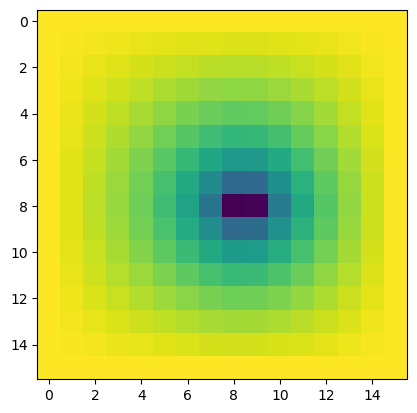

In [13]:
plt.imshow(status_array.reshape(L, L))

In [45]:
node = (L//2, L//2)
# Set the desired order
order = L
# Get the kth-order neighbors
neighbor_dict = nx.single_source_shortest_path_length(G, node)
# Extract the nodes at the kth order
kth_order_neighbors = [np.array(n) for n, d in neighbor_dict.items() if d == order]

In [ ]:
def radial_correlation(field, neighbor_dict):
    # Flatten the field array
    flattened_field = field.flatten()

    # Compute the mean of the field values
    mean_field = np.mean(flattened_field)

    # Compute the correlation function
    correlation = []
    for node, neighbors in neighbor_dict.items():
        if neighbors:  # Skip isolated nodes without neighbors
            correlations_node = []
            for neighbor in neighbors:
                correlation_node = np.mean((flattened_field[node] - mean_field) * flattened_field[neighbor]) / np.std(flattened_field) ** 2
                correlations_node.append(correlation_node)
            correlation.append(np.mean(correlations_node))

    return correlation

In [ ]:
import numpy as np
from scipy.spatial import distance

field_array = status_array.reshape(L,L)

correlation_values = radial_correlation(field_array)

In [ ]:
# def radial_correlation(data, distance):
#     center = np.array(data.shape) // 2  # Center of the array
#     correlations = []

#     for angle in range(360):
#         # Convert angle to radians
#         radian = np.deg2rad(angle)
        
#         # Calculate the neighbor's coordinates
#         x = int(center[0] + distance * np.cos(radian))
#         y = int(center[1] + distance * np.sin(radian))
        
#         # Calculate the correlation between the central point and the neighbor
#         correlation = np.corrcoef(data[center[0], center[1]], data[x, y])[0, 1]
#         correlations.append(correlation)

#     return correlations

# # Example usage
# array = status_array.reshape(L,L)  # Example 2D array
# distance = 2  # Distance for correlation measurement

# correlations = radial_correlation(array, distance)

# # Plotting
# angles = np.arange(0, 360)
# plt.plot(angles, correlations)
# plt.xlabel('Angle (degrees)')
# plt.ylabel('Correlation')
# plt.title(f'Radial Correlation at Distance {distance}')
# plt.grid(True)
# plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
#
# div = make_axes_locatable(ax)
# cax = div.append_axes('right', '5%', '5%')
#
cv0 = frames_dynsys[0]
im = ax.imshow(cv0, origin='lower') # Here make an AxesImage rather than contour
cb = fig.colorbar(im)
tx = ax.set_title('Frame 0')

def animate(i):
    arr = frames_dynsys[i]
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    tx.set_text('Frame {0}'.format(i))
    # In this version you don't have to do anything to the colorbar,
    # it updates itself when the mappable it watches (im) changes
 
ani = animation.FuncAnimation(fig, animate, frames=len(frames_dynsys))
writervideo = animation.FFMpegWriter(fps=5) 
ani.save("output2.mp4", writer=writervideo)

In [ ]:
colors = plt.cm.jet(np.linspace(0,1,100))

for i, (k, v) in enumerate(list(status_distributionp.items())[::5]):
    plt.plot(v[:, 0], v[:, 1], 'o-', label=fr"$t={t:g}$", color=colors[i])
plt.xlabel(r"$x_i$")
plt.ylabel(r"$P(x_i)$")
# plt.yscale('symlog')
# plt.xscale('log')

In [ ]:
# to be plotted as a function of idistance
for k, v in status_distributionx.items():
    plt.plot(v[:, 0], v[:, 1], 'o-', label=fr"$t={t:g}$")
# plt.yscale('symlog')
plt.xlabel(r"$i$")
plt.ylabel(r"$x_i$")
# plt.axvline(1)
# plt.axvline(2)
# plt.axvline(21)
# plt.axvline(381)

In [ ]:
plt.legend()
plt.yscale('log')
plt.xlabel(r"$\vec{x}$")
plt.ylabel(r"$P(\vec{x})$")

In [ ]:
def calculate_distance(node1, node2):
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])

# Assuming you have created the grid using nx.grid_2d_graph
nodes = list(grid.nodes())

# Find the coordinates (x1, y1) and (x2, y2) for nodes i and j
x1, y1 = nodes[i - 1]
x2, y2 = nodes[j - 1]

sorted_X = sorted(X, key=lambda node: calculate_distance(nodes[node - 1], (x1, y1)))

In [ ]:
status_array.shape

In [ ]:
sl.shape